Loaded 1,000,000 rows with columns: customer_id, treatment, pre_spend, post_spend, geo, factor_a, factor_b
Summary statistics:


,treatment,pre_spend,post_spend,factor_a,factor_b
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.500517,457.078024,461.738550,0.500172,0.500112
std,0.500000,433.277500,330.339986,0.500000,0.500000
min,0.000000,8.756696,30.996793,0.000000,0.000000
25%,0.000000,193.386515,257.223372,0.000000,0.000000
50%,1.000000,331.934819,375.522234,1.000000,1.000000
75%,1.000000,569.607675,560.942381,1.000000,1.000000
max,1.000000,20506.643645,15854.989226,1.000000,1.000000



Treatment group: 500,517 customers
Control group: 499,483 customers


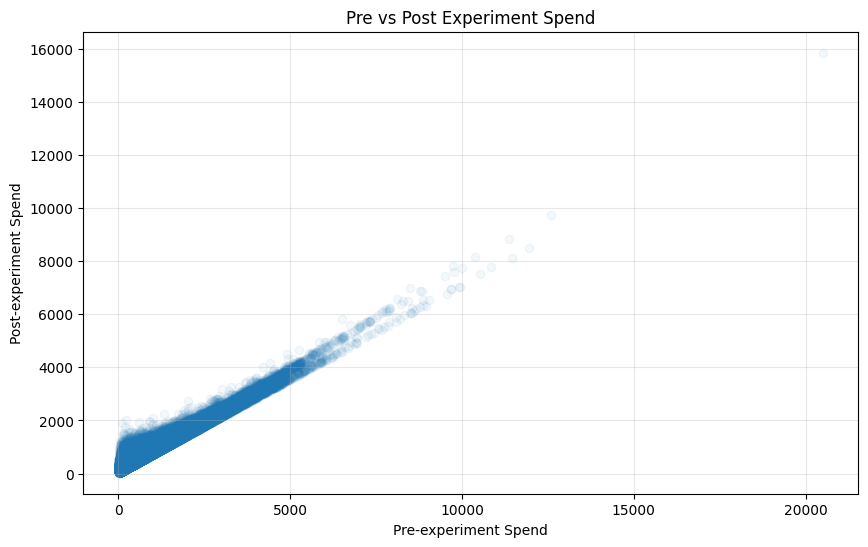

Estimating theta via OLS...
Estimated theta: 0.7003
R² value: 0.9367


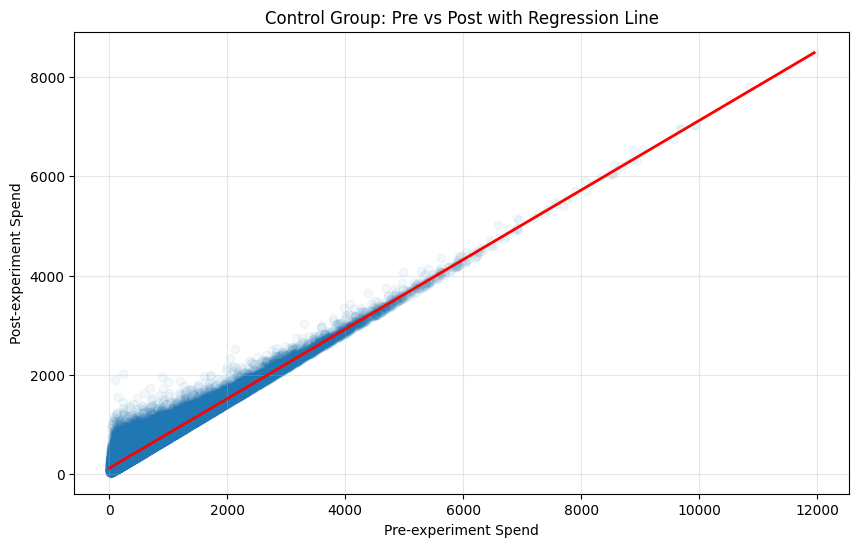

Naive treatment effect: 43.6484
CUPED-adjusted treatment effect: 44.0042
Variance reduction from CUPED: 93.25%
Lift Percentage: 10.00%
95% Confidence Interval: [9.93%, 10.08%]
p-value: 0.0000
The treatment effect is statistically significant at the 5% level.


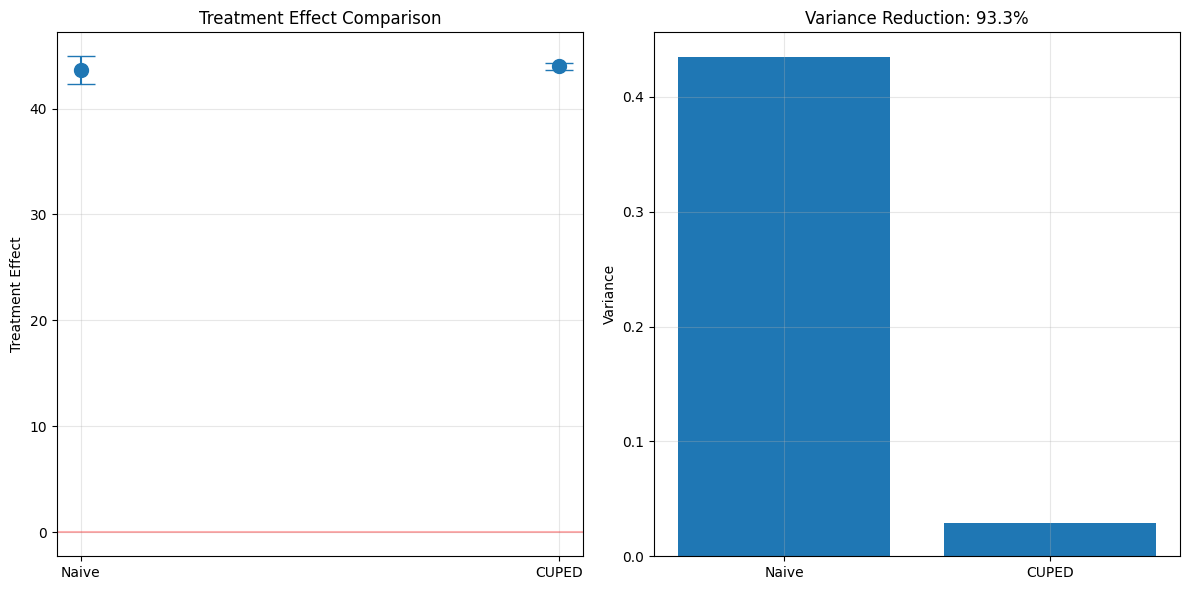

Final result for RL service:
{'metric': 'spend', 'lift_percentage': 10.0, 'confidence_interval': {'lower': 9.93, 'upper': 10.08}, 'p_value': 0.0, 'is_significant': True, 'sample_size': 1000000, 'variance_reduction_percentage': 93.25}


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.stats as stats











# Load dataset - update path if needed
data = pd.read_csv('data/pre_post_events.csv')
print(f"Loaded {len(data):,} rows with columns: {', '.join(data.columns)}")
data.head()












# Quick data exploration
print("Summary statistics:")
display(data.describe())

# Check treatment distribution
treatment_counts = data['treatment'].value_counts()
print(f"\nTreatment group: {treatment_counts.get(1, 0):,} customers")
print(f"Control group: {treatment_counts.get(0, 0):,} customers")

# Basic visualization of pre/post spend
plt.figure(figsize=(10, 6))
plt.scatter(data['pre_spend'], data['post_spend'], alpha=0.05)
plt.xlabel('Pre-experiment Spend')
plt.ylabel('Post-experiment Spend')
plt.title('Pre vs Post Experiment Spend')
plt.grid(True, alpha=0.3)
plt.show()








# Step 1: Estimate theta using OLS on control data
print("Estimating theta via OLS...")
control_data = data[data['treatment'] == 0]
X = control_data[['pre_spend']]
y = control_data['post_spend']

model = LinearRegression()
model.fit(X, y)
theta = model.coef_[0]

print(f"Estimated theta: {theta:.4f}")
print(f"R² value: {model.score(X, y):.4f}")

# Plot regression line
plt.figure(figsize=(10, 6))
plt.scatter(control_data['pre_spend'], control_data['post_spend'], alpha=0.05)
x_range = np.linspace(control_data['pre_spend'].min(), control_data['pre_spend'].max(), 100)
plt.plot(x_range, model.intercept_ + theta * x_range, 'r-', linewidth=2)
plt.xlabel('Pre-experiment Spend')
plt.ylabel('Post-experiment Spend')
plt.title('Control Group: Pre vs Post with Regression Line')
plt.grid(True, alpha=0.3)
plt.show()









# Step 2: Apply CUPED adjustment
pre_mean = data['pre_spend'].mean()
data['adjusted_post_spend'] = data['post_spend'] - theta * (data['pre_spend'] - pre_mean)

# Calculate treatment effects
treatment_data = data[data['treatment'] == 1]
control_data = data[data['treatment'] == 0]

# Naive treatment effect
naive_effect = treatment_data['post_spend'].mean() - control_data['post_spend'].mean()

# CUPED-adjusted treatment effect
cuped_effect = treatment_data['adjusted_post_spend'].mean() - control_data['adjusted_post_spend'].mean()

print(f"Naive treatment effect: {naive_effect:.4f}")
print(f"CUPED-adjusted treatment effect: {cuped_effect:.4f}")

# Calculate standard errors and confidence intervals
treatment_n = len(treatment_data)
control_n = len(control_data)

# Naive standard error
naive_se = np.sqrt(
    treatment_data['post_spend'].var() / treatment_n + 
    control_data['post_spend'].var() / control_n
)

# CUPED standard error
cuped_se = np.sqrt(
    treatment_data['adjusted_post_spend'].var() / treatment_n + 
    control_data['adjusted_post_spend'].var() / control_n
)

# Variance reduction
variance_reduction = 1 - (cuped_se**2 / naive_se**2)
print(f"Variance reduction from CUPED: {variance_reduction:.2%}")














# Step 3: Calculate lift percentage and confidence intervals
control_mean = control_data['post_spend'].mean()
lift_percentage = (cuped_effect / control_mean) * 100

# 95% confidence interval
lift_ci_lower = (cuped_effect - 1.96 * cuped_se) / control_mean * 100
lift_ci_upper = (cuped_effect + 1.96 * cuped_se) / control_mean * 100

print(f"Lift Percentage: {lift_percentage:.2f}%")
print(f"95% Confidence Interval: [{lift_ci_lower:.2f}%, {lift_ci_upper:.2f}%]")

# Check if treatment effect is statistically significant
p_value = 2 * (1 - stats.norm.cdf(abs(cuped_effect) / cuped_se))
print(f"p-value: {p_value:.4f}")
print(f"The treatment effect is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at the 5% level.")

# Visualize results
plt.figure(figsize=(12, 6))

# Compare treatment effects
plt.subplot(1, 2, 1)
plt.errorbar(['Naive', 'CUPED'], 
             [naive_effect, cuped_effect],
             yerr=[1.96 * naive_se, 1.96 * cuped_se],
             fmt='o', capsize=10, markersize=10)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Treatment Effect Comparison')
plt.ylabel('Treatment Effect')
plt.grid(alpha=0.3)

# Compare variances
plt.subplot(1, 2, 2)
plt.bar(['Naive', 'CUPED'], [naive_se**2, cuped_se**2])
plt.title(f'Variance Reduction: {variance_reduction:.1%}')
plt.ylabel('Variance')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()












# Create JSON-compatible output for RL service
result = {
    "metric": "spend",
    "lift_percentage": round(lift_percentage, 2),
    "confidence_interval": {
        "lower": round(lift_ci_lower, 2),
        "upper": round(lift_ci_upper, 2)
    },
    "p_value": round(p_value, 4),
    "is_significant": p_value < 0.05,
    "sample_size": treatment_n + control_n,
    "variance_reduction_percentage": round(variance_reduction * 100, 2)
}

print("Final result for RL service:")
print(result)



In [34]:
# Load dataset - update path if needed
data = pd.read_csv('data/pre_post_events.csv')
print(f"Loaded {len(data):,} rows with columns: {', '.join(data.columns)}")
data.head()

Loaded 1,000,000 rows with columns: customer_id, treatment, pre_spend, post_spend, geo, factor_a, factor_b


,customer_id,treatment,pre_spend,post_spend,geo,factor_a,factor_b
0,cust_0000000,0,388.647516,409.013722,geo_3,0,1
1,cust_0000001,1,104.108088,119.379209,geo_5,0,1
2,cust_0000002,1,533.255729,440.708404,geo_3,1,1
3,cust_0000003,1,215.050331,317.239618,geo_4,0,0
4,cust_0000004,0,422.566763,334.149619,geo_4,0,1


Summary statistics:


,treatment,pre_spend,post_spend,factor_a,factor_b
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.500517,457.078024,461.738550,0.500172,0.500112
std,0.500000,433.277500,330.339986,0.500000,0.500000
min,0.000000,8.756696,30.996793,0.000000,0.000000
25%,0.000000,193.386515,257.223372,0.000000,0.000000
50%,1.000000,331.934819,375.522234,1.000000,1.000000
75%,1.000000,569.607675,560.942381,1.000000,1.000000
max,1.000000,20506.643645,15854.989226,1.000000,1.000000



Treatment group: 500,517 customers
Control group: 499,483 customers


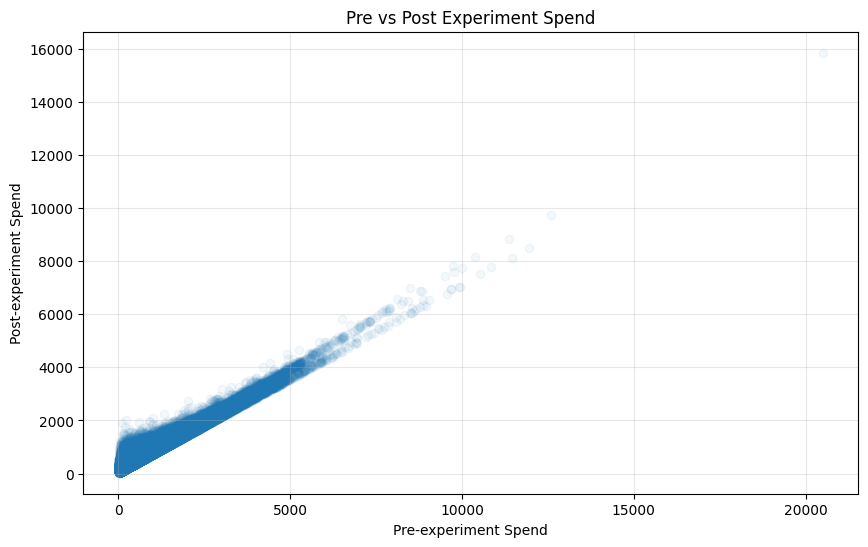

In [35]:
# Quick data exploration
print("Summary statistics:")
display(data.describe())

# Check treatment distribution
treatment_counts = data['treatment'].value_counts()
print(f"\nTreatment group: {treatment_counts.get(1, 0):,} customers")
print(f"Control group: {treatment_counts.get(0, 0):,} customers")

# Basic visualization of pre/post spend
plt.figure(figsize=(10, 6))
plt.scatter(data['pre_spend'], data['post_spend'], alpha=0.05)
plt.xlabel('Pre-experiment Spend')
plt.ylabel('Post-experiment Spend')
plt.title('Pre vs Post Experiment Spend')
plt.grid(True, alpha=0.3)
plt.show()

Estimating theta via OLS...
Estimated theta: 0.7003
R² value: 0.9367


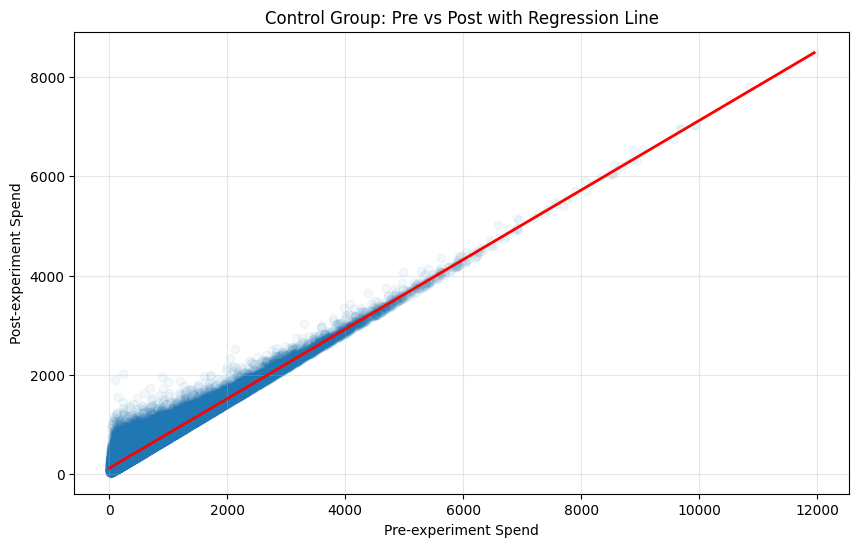

In [36]:
# Step 1: Estimate theta using OLS on control data
print("Estimating theta via OLS...")
control_data = data[data['treatment'] == 0]
X = control_data[['pre_spend']]
y = control_data['post_spend']

model = LinearRegression()
model.fit(X, y)
theta = model.coef_[0]

print(f"Estimated theta: {theta:.4f}")
print(f"R² value: {model.score(X, y):.4f}")

# Plot regression line
plt.figure(figsize=(10, 6))
plt.scatter(control_data['pre_spend'], control_data['post_spend'], alpha=0.05)
x_range = np.linspace(control_data['pre_spend'].min(), control_data['pre_spend'].max(), 100)
plt.plot(x_range, model.intercept_ + theta * x_range, 'r-', linewidth=2)
plt.xlabel('Pre-experiment Spend')
plt.ylabel('Post-experiment Spend')
plt.title('Control Group: Pre vs Post with Regression Line')
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
# Step 2: Apply CUPED adjustment
pre_mean = data['pre_spend'].mean()
data['adjusted_post_spend'] = data['post_spend'] - theta * (data['pre_spend'] - pre_mean)

# Calculate treatment effects
treatment_data = data[data['treatment'] == 1]
control_data = data[data['treatment'] == 0]

# Naive treatment effect
naive_effect = treatment_data['post_spend'].mean() - control_data['post_spend'].mean()

# CUPED-adjusted treatment effect
cuped_effect = treatment_data['adjusted_post_spend'].mean() - control_data['adjusted_post_spend'].mean()

print(f"Naive treatment effect: {naive_effect:.4f}")
print(f"CUPED-adjusted treatment effect: {cuped_effect:.4f}")

# Calculate standard errors and confidence intervals
treatment_n = len(treatment_data)
control_n = len(control_data)

# Naive standard error
naive_se = np.sqrt(
    treatment_data['post_spend'].var() / treatment_n + 
    control_data['post_spend'].var() / control_n
)

# CUPED standard error
cuped_se = np.sqrt(
    treatment_data['adjusted_post_spend'].var() / treatment_n + 
    control_data['adjusted_post_spend'].var() / control_n
)

# Variance reduction
variance_reduction = 1 - (cuped_se**2 / naive_se**2)
print(f"Variance reduction from CUPED: {variance_reduction:.2%}")

Naive treatment effect: 43.6484
CUPED-adjusted treatment effect: 44.0042
Variance reduction from CUPED: 93.25%


Lift Percentage: 10.00%
95% Confidence Interval: [9.93%, 10.08%]
p-value: 0.0000
The treatment effect is statistically significant at the 5% level.


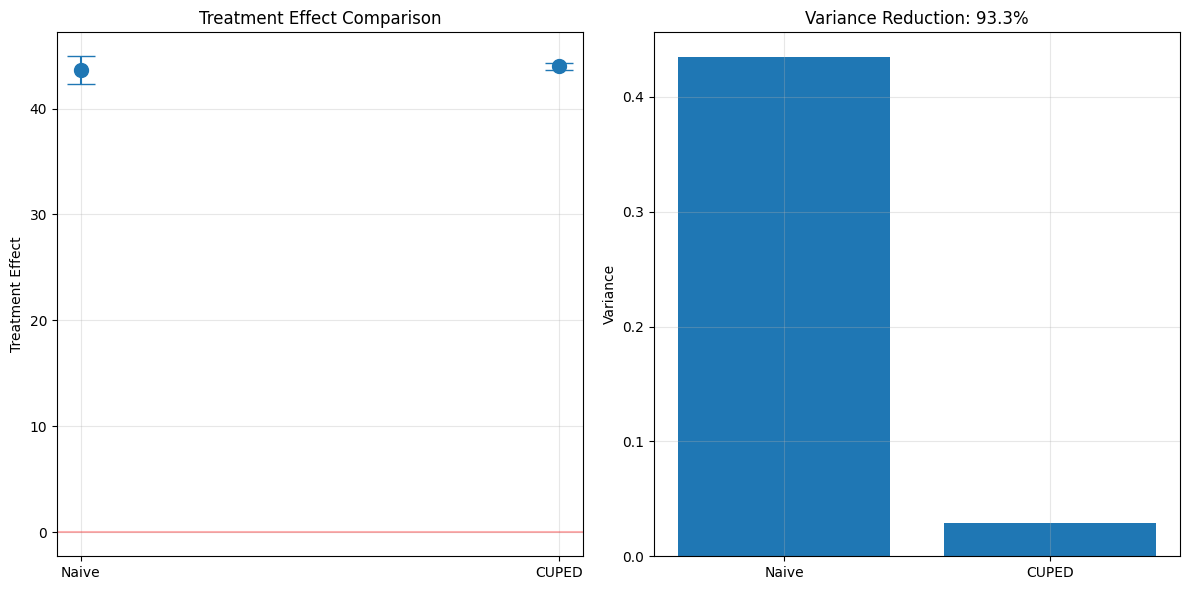

In [38]:
# Step 3: Calculate lift percentage and confidence intervals
control_mean = control_data['post_spend'].mean()
lift_percentage = (cuped_effect / control_mean) * 100

# 95% confidence interval
lift_ci_lower = (cuped_effect - 1.96 * cuped_se) / control_mean * 100
lift_ci_upper = (cuped_effect + 1.96 * cuped_se) / control_mean * 100

print(f"Lift Percentage: {lift_percentage:.2f}%")
print(f"95% Confidence Interval: [{lift_ci_lower:.2f}%, {lift_ci_upper:.2f}%]")

# Check if treatment effect is statistically significant
p_value = 2 * (1 - stats.norm.cdf(abs(cuped_effect) / cuped_se))
print(f"p-value: {p_value:.4f}")
print(f"The treatment effect is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at the 5% level.")

# Visualize results
plt.figure(figsize=(12, 6))

# Compare treatment effects
plt.subplot(1, 2, 1)
plt.errorbar(['Naive', 'CUPED'], 
             [naive_effect, cuped_effect],
             yerr=[1.96 * naive_se, 1.96 * cuped_se],
             fmt='o', capsize=10, markersize=10)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Treatment Effect Comparison')
plt.ylabel('Treatment Effect')
plt.grid(alpha=0.3)

# Compare variances
plt.subplot(1, 2, 2)
plt.bar(['Naive', 'CUPED'], [naive_se**2, cuped_se**2])
plt.title(f'Variance Reduction: {variance_reduction:.1%}')
plt.ylabel('Variance')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()